# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings # Suprimir todos los warnings 
import wittgenstein as lw
# import plotly.express as px 
# import plotly.subplots as sp 
# import plotly.graph_objects as go


# from scipy.io.arff import loadarff
from sklearn.datasets import fetch_openml
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


warnings.filterwarnings('ignore')

# Data

In [2]:
# Descargar el dataset desde OpenML
data = fetch_openml(data_id=1464, as_frame=True)

# Separar características (X) y etiqueta objetivo (y)
X = data.data
y = data.target

# Combinar características y objetivo en un único DataFrame
df = pd.concat([X, y.rename('Donated')], axis=1)

In [3]:
# # Ruta del archivo ARFF
# file_path = "php0iVrYT.arff" 

# # Cargar el archivo ARFF
# with open(file_path, 'r') as file:
#     data, meta = loadarff(file)

# # Convertir los datos en un DataFrame
# df = pd.DataFrame(data)

# # Decodificar valores tipo bytes a strings (si es necesario)
# df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


## Descripción del DataSet

Conjunto de datos del Centro de Servicios de Transfusión de Sangre Los datos tomados del Centro de Servicios de Transfusión de Sangre en la ciudad de Hsin-Chu en Taiwán.

Para demostrar el modelo de comercialización de RFMTC (una versión modificada de RFM), este estudio adoptó la base de datos de donantes del Centro de Servicios de Transfusión de Sangre en la ciudad de Hsin-Chu en Taiwán. El centro pasa su autobús de servicio de transfusión de sangre a una universidad en la ciudad de Hsin-Chu para recolectar la sangre donada aproximadamente cada tres meses. Para construir un modelo FRMTC, seleccionamos 748 donantes al azar de la base de datos de donantes.

***Información de atributos:***

- V1: Reciente: meses desde la última donación
- V2: Frecuencia - número total de donaciones
- V3: Monetario - total de sangre donada en centimetro cúbicos.
- V4: Tiempo - meses desde la primera donación.
- Donated: Variable binaria que representa si donó sangre en marzo de 2007 (2 significa donar sangre; 1 significa no donar sangre).

# Análisis exploratotio

In [4]:
# Mostrar las primeras filas del DataFrame
df.head()

,V1,V2,V3,V4,Donated
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1


In [5]:
#Elimiar filas vacías
df = df.dropna(how='all')

#Tamaño del dataset
df.shape

(748, 5)

In [6]:
#Obserar columnas del DataSet
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'Donated'], dtype='object')

In [7]:
# Renombrar las columnas 
df.rename(columns={ 
    'V1': 'ULTIMA DONACION', 
    'V2': 'TOTAL DE DONACIONES',
    'V3': 'TOTAL SANGRE DONADA',
    'V4': 'MESES PRIMERA DONACION',
    'Donated': "DONADOR"
    }, inplace=True)

In [8]:
#Observar columnas del DataSet
df.columns

Index(['ULTIMA DONACION', 'TOTAL DE DONACIONES', 'TOTAL SANGRE DONADA',
       'MESES PRIMERA DONACION', 'DONADOR'],
      dtype='object')

## Número de clases y lo que representan

In [9]:
#Clases por variable
for i in df.columns:
    print(f"Clases de la varible {i}: \n{df[i].unique()}\n")

Clases de la varible ULTIMA DONACION: 
[ 2  0  1  4  5  9  3 12  6 11 10 13  8 14  7 16 15 23 21 18 22 26 35 38
 40 74 20 17 25 39 72]

Clases de la varible TOTAL DE DONACIONES: 
[50 13 16 20 24  4  7 12  9 46 23  3 10  6  5 14 15 11  8  2 19 17  1 22
 18 38 43 34 44 26 41 21 33]

Clases de la varible TOTAL SANGRE DONADA: 
[12500  3250  4000  5000  6000  1000  1750  3000  2250 11500  5750   750
  2500  1500  1250  3500  3750  2750  2000   500  4750  4250   250  5500
  4500  9500 10750  8500 11000  6500 10250  5250  8250]

Clases de la varible MESES PRIMERA DONACION: 
[98 28 35 45 77  4 14 22 58 47 15 11 48 49 16 40 34 21 26 64 57 53 69 36
  2 46 52 81 29  9 74 25 51 71 23 86 38 76 70 59 82 61 79 41 33 10 95 88
 19 37 39 78 42 27 24 63 43 75 73 50 60 17 72 62 30 31 65 89 87 93 83 32
 12 18 55  3 13 54]

Clases de la varible DONADOR: 
['2', '1']
Categories (2, object): ['1', '2']



In [10]:
#Observar el número de clases 
num_clases = df.nunique()
print(f"Número de clases\n{num_clases}")

Número de clases
ULTIMA DONACION           31
TOTAL DE DONACIONES       33
TOTAL SANGRE DONADA       33
MESES PRIMERA DONACION    78
DONADOR                    2
dtype: int64


<span style="color: #0088b6; font-weight: bold;">Nota:</span> La variable "DONADOR" es categórica binaria, donde 2 es que la persona sí dona sangre y 1 que la persona no dona sangre.
Del mismo modo, se puede evidenciar que ninguna de las variables presenta datos nulos, lo cual se puede evidenciar en el código de la siguiente línea


## Datos nulos

In [11]:
#Datos nulos en el DataSet
df.isnull().sum()

ULTIMA DONACION           0
TOTAL DE DONACIONES       0
TOTAL SANGRE DONADA       0
MESES PRIMERA DONACION    0
DONADOR                   0
dtype: int64

## Número de instancias e instancias por clase

In [12]:
#Total de instancias del dataset
print(f"Número total de instancias: {df.shape[0]}")

Número total de instancias: 748


In [13]:
#Instancias por clase
for i in df.columns: 
    print(f"Clases de la variable {i}:") 
    display(df[i].value_counts().to_frame('Frecuencia')) 
    print("\n")

Clases de la variable ULTIMA DONACION:


,Frecuencia
ULTIMA DONACION,
2,173
4,156
11,84
14,76
16,63
23,50
21,44
9,20
3,13




Clases de la variable TOTAL DE DONACIONES:


,Frecuencia
TOTAL DE DONACIONES,
1,158
2,112
3,87
5,62
4,62
6,52
7,43
8,31
9,24




Clases de la variable TOTAL SANGRE DONADA:


,Frecuencia
TOTAL SANGRE DONADA,
250,158
500,112
750,87
1250,62
1000,62
1500,52
1750,43
2000,31
2250,24




Clases de la variable MESES PRIMERA DONACION:


,Frecuencia
MESES PRIMERA DONACION,
4,57
16,51
14,44
2,36
23,36
...,...
12,1
55,1
3,1




Clases de la variable DONADOR:


,Frecuencia
DONADOR,
1,570
2,178


## Número y tipo de atributos

In [14]:
#Conocer el tipo de los datos
df.dtypes

ULTIMA DONACION              int64
TOTAL DE DONACIONES          int64
TOTAL SANGRE DONADA          int64
MESES PRIMERA DONACION       int64
DONADOR                   category
dtype: object

In [15]:
#Cantidad de atributos
print(f"\nNúmero de atributos: {df.shape[1]}")


Número de atributos: 5


## Estadísticas de tendencia central

### Media, desviación estandar, min, max y rangos intercuartiles

In [16]:
df.describe()

,ULTIMA DONACION,TOTAL DE DONACIONES,TOTAL SANGRE DONADA,MESES PRIMERA DONACION
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


### Mediana

In [17]:
# Crear una lista para almacenar los resultados 
resultados = []

# Iterar sobre las columnas excepto la última 
for i in df.columns[:-1]: 
    mediana = np.median(df[i]) 
    resultados.append({'Variable': i, 'Mediana': mediana}) 
    
# Convertir los resultados en un DataFrame tabla_resultados =
tabla_resultados = pd.DataFrame(resultados)
tabla_resultados

,Variable,Mediana
0,ULTIMA DONACION,7.0
1,TOTAL DE DONACIONES,4.0
2,TOTAL SANGRE DONADA,1000.0
3,MESES PRIMERA DONACION,28.0


## Visualización de los datos

### Histograma de frecuencias

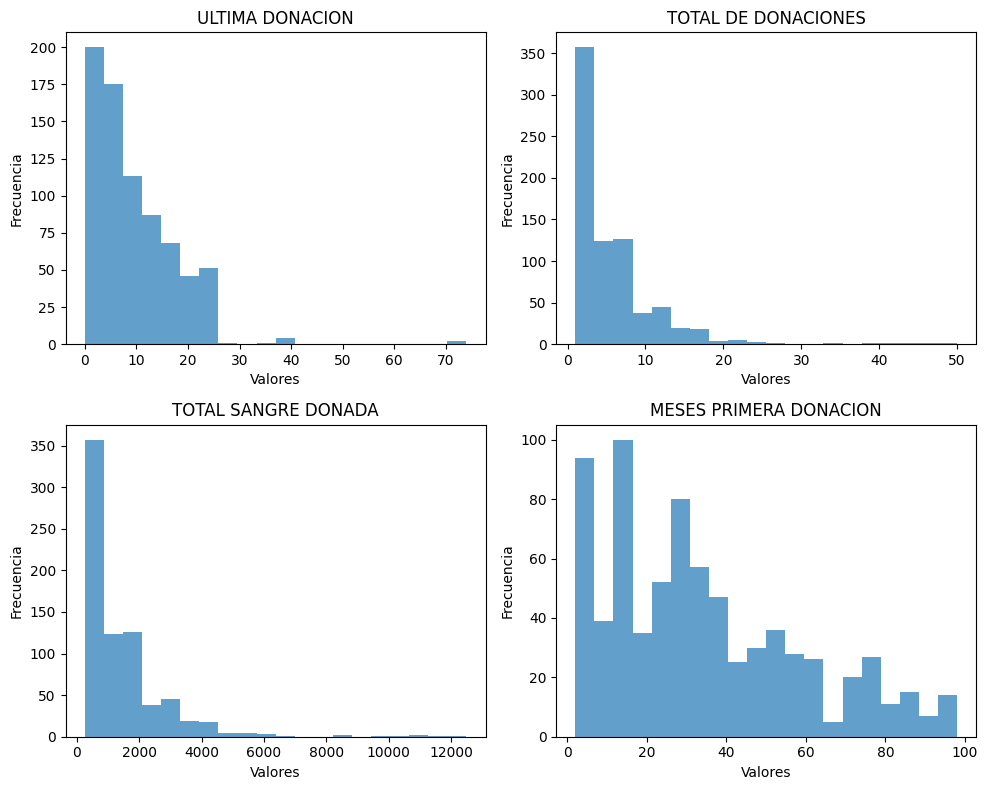

In [18]:
# Crear una figura y ejes para la matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Lista de columnas a graficar
columnas = df.columns[:-1]

# Iterar sobre las columnas y los ejes para crear los histogramas
for i, column in enumerate(columnas):
    row, col = divmod(i, 2)
    # Histograma
    axes[row, col].hist(df[column], bins=20, alpha=0.7, density=False)
    
    # Ajustar título del histograma con el nombre de la variable
    axes[row, col].set_title(f'{column}')
    
    # Etiquetas de los ejes
    axes[row, col].set_xlabel('Valores')
    axes[row, col].set_ylabel('Frecuencia')
    
# Ajustar el layout para que no se superpongan los títulos y etiquetas
plt.tight_layout()

### Histogramas de distribución normal de datos 

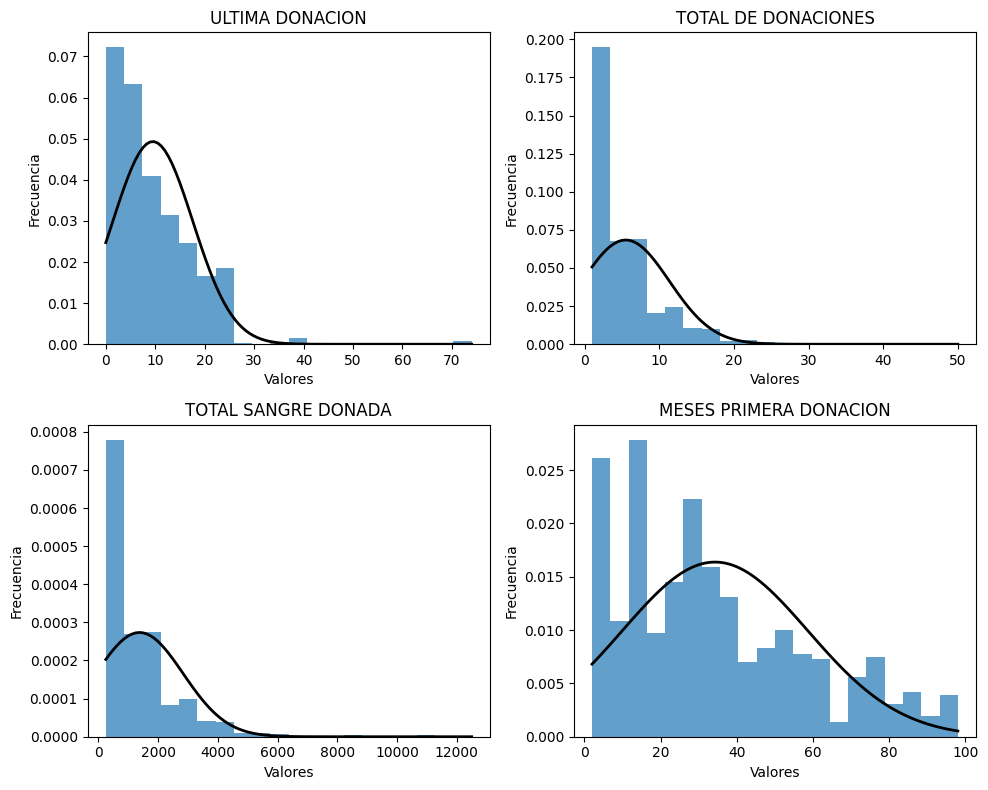

In [19]:
# Crear una figura y ejes para la matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Lista de columnas a graficar
columnas = df.columns[:-1]

# Iterar sobre las columnas y los ejes para crear los histogramas
for i, column in enumerate(columnas):
    row, col = divmod(i, 2)
    # Histograma
    axes[row, col].hist(df[column], bins=20, alpha=0.7, density=True)
    
    # Ajustar título del histograma con el nombre de la variable
    axes[row, col].set_title(f'{column}')
    
    # Etiquetas de los ejes
    axes[row, col].set_xlabel('Valores')
    axes[row, col].set_ylabel('Frecuencia')
    
    # Ajustar la distribución normal
    mean, std = norm.fit(df[column])
    x = np.linspace(df[column].min(), df[column].max(), 100)
    p = norm.pdf(x, mean, std)
    axes[row, col].plot(x, p, 'k', linewidth=2)

# Ajustar el layout para que no se superpongan los títulos y etiquetas
plt.tight_layout()

### Visualización de datos atipicos

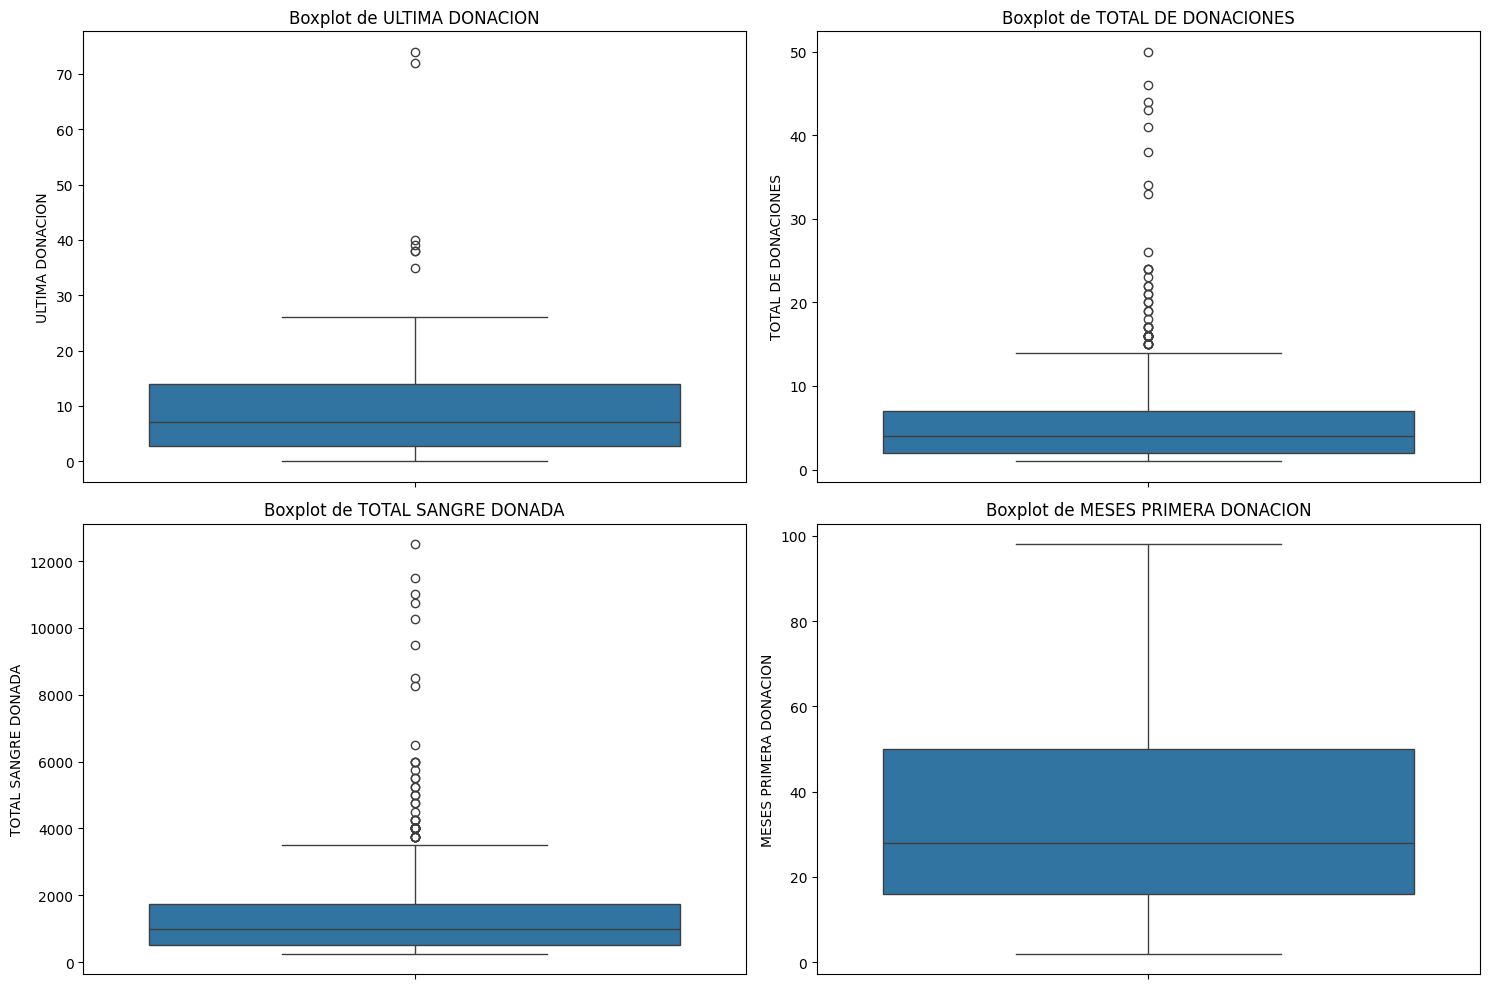

In [20]:
# Filtrar las columnas excluyendo 'Donador'
columns_to_plot = df.columns[:-1]

# Crear la figura y los ejes para los boxplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Iterar sobre las columnas y crear un boxplot para cada una
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)
    sns.boxplot(data=df, y=column, ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot de {column}')

# Ocultar gráficos vacíos si hay menos de cuatro variables a graficar
if len(columns_to_plot) < 4:
    for j in range(len(columns_to_plot), 4):
        row, col = divmod(j, 2)
        axes[row, col].axis('off')

# Ajustar el layout para que no se superpongan los títulos y etiquetas
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [21]:
                                                #########################################
                                                ############ CON PLOTLY #################
                                                ########################################

# # Filtrar las columnas excluyendo 'Donador'
# columns_to_plot = df.columns[:-1]

# # Crear la figura para los subplots
# fig = sp.make_subplots(rows=2, cols=2, subplot_titles=[f'Boxplot de {col}' for col in columns_to_plot])

# # Iterar sobre las columnas y crear un boxplot para cada una
# for i, column in enumerate(columns_to_plot):
#     row, col = divmod(i, 2)
#     fig.add_trace(
#         go.Box(y=df[column], name=column, boxmean=True),
#         row=row+1, col=col+1
#     )

# # Ocultar subplots vacíos si hay menos de cuatro variables a graficar
# if len(columns_to_plot) < 4:
#     for j in range(len(columns_to_plot), 4):
#         row, col = divmod(j, 2)
#         fig.update_xaxes(visible=False, row=row+1, col=col+1)
#         fig.update_yaxes(visible=False, row=row+1, col=col+1)

# # Actualizar el layout para los títulos y etiquetas
# fig.update_layout(height=600, width=800, title_text='Boxplots por Variable', showlegend=False)

# # Mostrar los gráficos
# fig.show()


<span style="color: #0088b6; font-weight: bold;">Nota:</span> Se deja los outliers por la naturaleza de los datos, ya que estos pueden ser considerados normales. Del mismo modo, se realizará después un tratamiento de datos atipicos y se evaluará los modelos sin estos outliers. 

### Visualización de la variable categorica

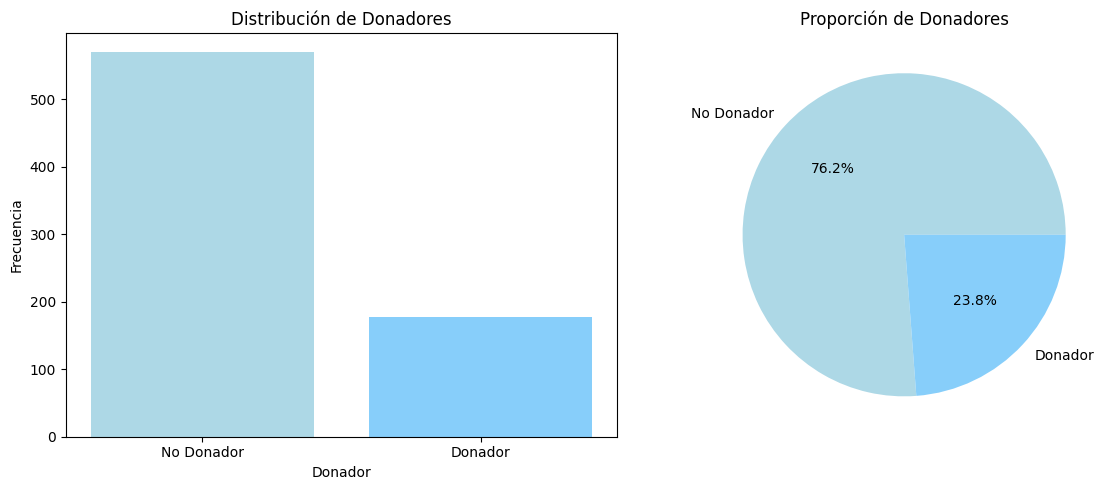

In [22]:
# Contar la frecuencia de cada categoría
counts = df['DONADOR'].value_counts()
labels = ['No Donador', 'Donador']

# Crear una figura para la matriz 1x2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila y 2 columnas

# Gráfico de Barras
axes[0].bar(labels, counts.values, color=['#ADD8E6', '#87CEFA'])
axes[0].set_xlabel('Donador')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Donadores')

# Gráfico de Torta
axes[1].pie(counts, labels=labels, autopct='%1.1f%%', colors=['#ADD8E6', '#87CEFA'])
axes[1].set_title('Proporción de Donadores')

# Ajustar el layout para que no se superpongan los títulos y etiquetas
plt.tight_layout()

# Mostrar los gráficos
plt.show()


In [23]:
# # Contar la frecuencia de cada categoría
# counts = df['DONADOR'].value_counts()
# labels = ['No Donador', 'Donador']

# # Crear la figura con una matriz 2x2
# fig = sp.make_subplots(rows=2, cols=2, specs=[[{"type": "bar"}, {"type": "pie"}], [{"colspan": 2}, None]])

# # Agregar gráfico de barras
# fig.add_trace(go.Bar(x=labels, y=counts.values, name='Barras', marker_color=['blue', 'orange']), row=1, col=1)

# # Agregar gráfico de torta
# fig.add_trace(go.Pie(labels=labels, values=counts.values, name='Torta', marker_colors=['blue', 'orange']), row=1, col=2)

# # Actualizar el diseño del gráfico
# fig.update_layout(
#     title_text="Distribución de Donadores",
#     showlegend=False
# )

# # Mostrar la figura
# fig.show()


## Análisis multivariado y bivariado

### Matriz de regresiones

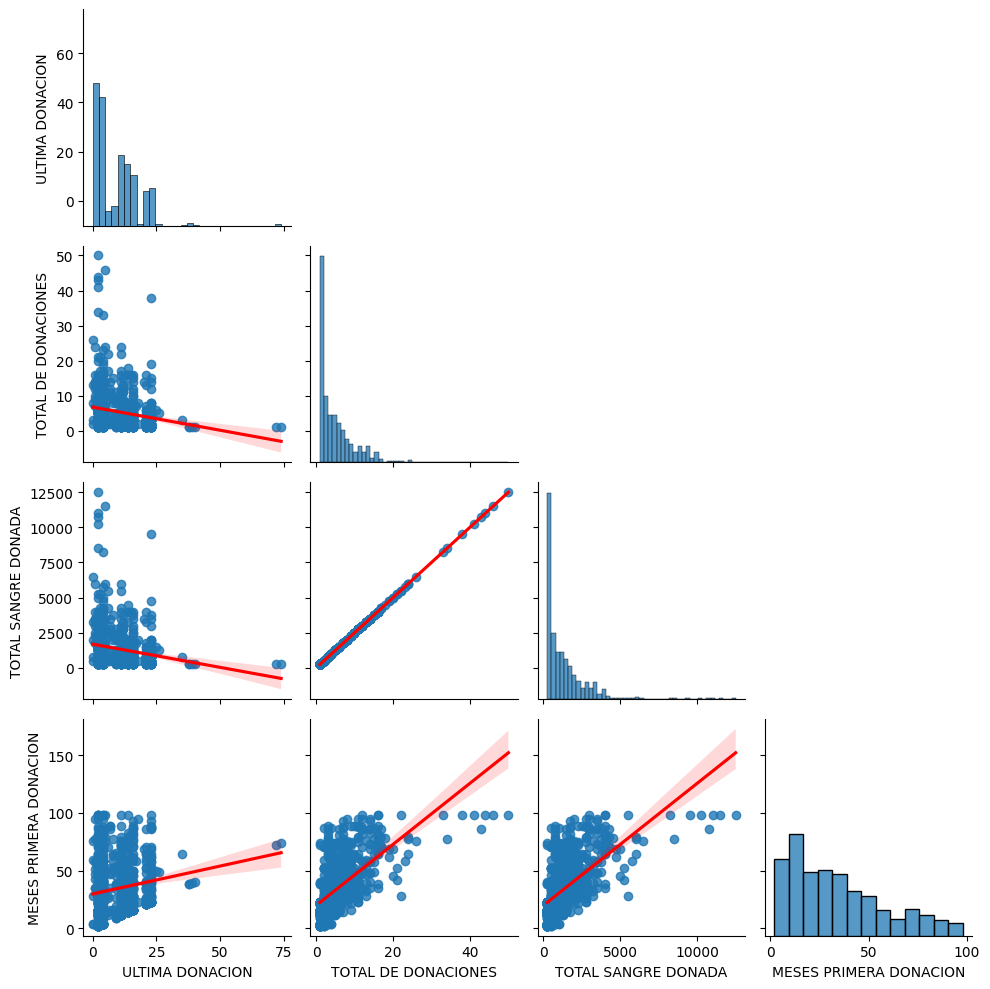

In [24]:
# Crear una matriz de regresiones excluyendo la columna 'Donador', mostrando solo la parte superior de la diagonal
g = sns.pairplot(df.iloc[:, :-1], kind='reg', plot_kws={'line_kws': {'color': 'red'}})

# Ocultar la parte inferior de la diagonal
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()


#### Estadisticos de la matriz de regresiones

In [25]:
# Filtrar las columnas excluyendo 'Donador'
columns_to_plot = df.columns[:-1]

# Función para realizar regresiones y obtener estadísticos
def regresion_estadisticas(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return model.rsquared, model.rsquared_adj, model.f_pvalue, model.aic, model.params

# Crear una lista para almacenar los resultados
resultados_lista = []

# Iterar sobre todas las combinaciones de variables
for x_var in columns_to_plot:
    for y_var in columns_to_plot:
        if x_var != y_var:
            r2, r2_adj, f_pval, aic, params = regresion_estadisticas(df[x_var], df[y_var])
            coef = params[1]  # Coeficiente de la variable independiente
            resultados_lista.append({
                'Variable_X': x_var,
                'Variable_Y': y_var,
                'R_squared': r2,
                'R_squared_adj': r2_adj,
                'F_pvalue': f_pval,
                'AIC': aic,
                'Coef': coef
            })

# Convertir la lista de resultados a un DataFrame
resultados = pd.DataFrame(resultados_lista)

# Mostrar los resultados
resultados


,Variable_X,Variable_Y,R_squared,R_squared_adj,F_pvalue,AIC,Coef
0,ULTIMA DONACION,TOTAL DE DONACIONES,0.033396,0.032100,4.851642e-07,4740.184367,-0.131817
1,ULTIMA DONACION,TOTAL SANGRE DONADA,0.033396,0.032100,4.851642e-07,13000.289900,-32.954131
2,ULTIMA DONACION,MESES PRIMERA DONACION,0.025798,0.024492,1.013926e-05,6883.849072,0.483650
3,TOTAL DE DONACIONES,ULTIMA DONACION,0.033396,0.032100,4.851642e-07,5228.902604,-0.253351
4,TOTAL DE DONACIONES,TOTAL SANGRE DONADA,1.000000,1.000000,0.000000e+00,-36924.430126,250.000000
5,TOTAL DE DONACIONES,MESES PRIMERA DONACION,0.403149,0.402349,1.147592e-85,6517.365542,2.650615
6,TOTAL SANGRE DONADA,ULTIMA DONACION,0.033396,0.032100,4.851642e-07,5228.902604,-0.001013
7,TOTAL SANGRE DONADA,TOTAL DE DONACIONES,1.000000,1.000000,0.000000e+00,-44921.849912,0.004000
8,TOTAL SANGRE DONADA,MESES PRIMERA DONACION,0.403149,0.402349,1.147592e-85,6517.365542,0.010602
9,MESES PRIMERA DONACION,ULTIMA DONACION,0.025798,0.024492,1.013926e-05,5234.759072,0.053341


#### Boxplot conparativos entre variables independientes asociado a la variable dependiente

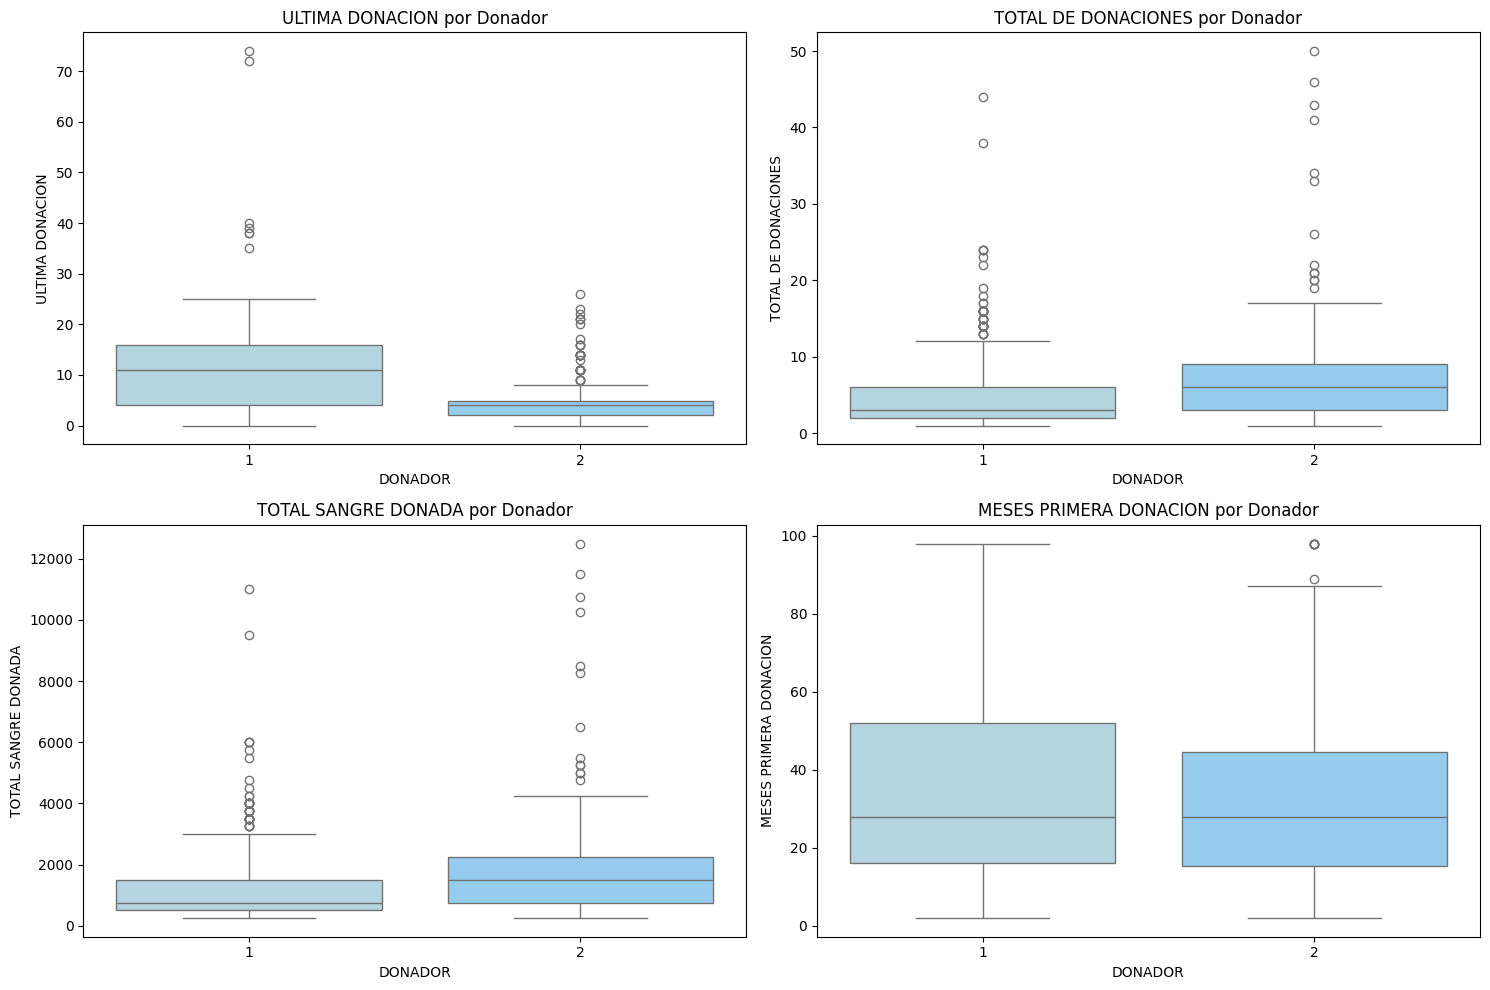

In [26]:
# Filtrar las columnas excluyendo 'Donador'
columns_to_plot = df.columns[:-1]

# Crear la figura y los ejes para los boxplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Iterar sobre las columnas y crear un boxplot para cada una
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)
    sns.boxplot(data=df, x='DONADOR', y=column, ax=axes[row, col], palette=['#ADD8E6', '#87CEFA'])
    axes[row, col].set_title(f'{column} por Donador')

# Ocultar gráficos vacíos si hay menos de cuatro variables a graficar
if len(columns_to_plot) < 4:
    for j in range(len(columns_to_plot), 4):
        row, col = divmod(j, 2)
        axes[row, col].axis('off')

# Ajustar el layout para que no se superpongan los títulos y etiquetas
plt.tight_layout()


#### Gráficos de violin comparativos

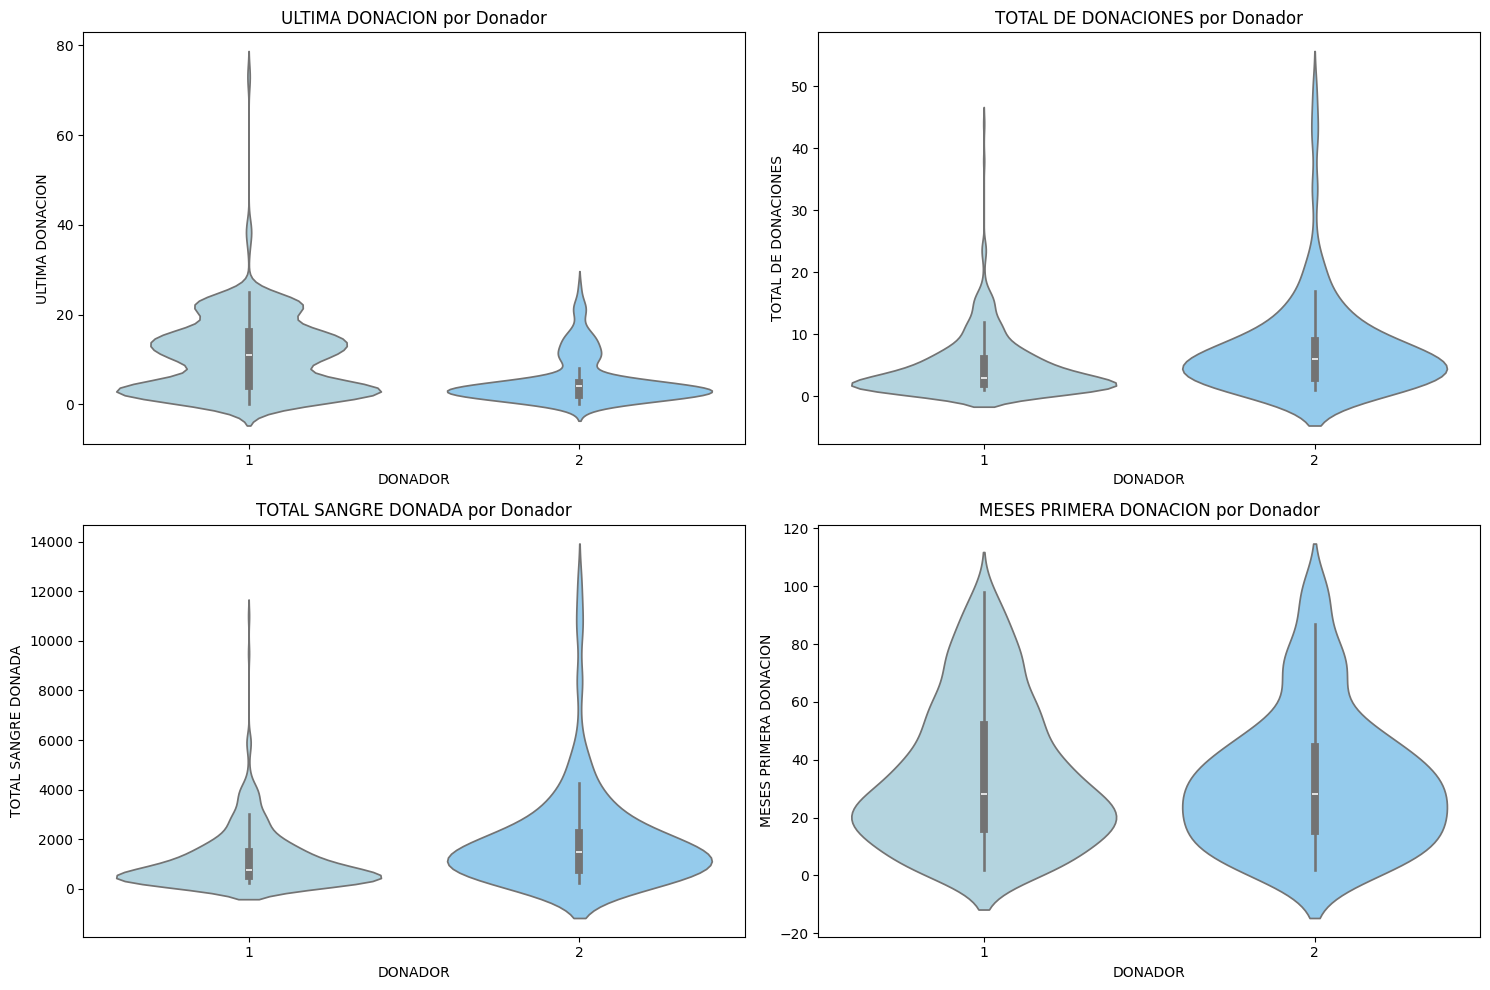

In [27]:
# Filtrar las columnas excluyendo 'Donador'
columns_to_plot = df.columns[:-1]

# Crear la figura y los ejes para los gráficos de violín
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Iterar sobre las columnas y crear un gráfico de violín para cada una
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)
    sns.violinplot(data=df, x='DONADOR', y=column, ax=axes[row, col], palette=['#ADD8E6', '#87CEFA'])
    axes[row, col].set_title(f'{column} por Donador')

# Ocultar gráficos vacíos si hay menos de cuatro variables a graficar
if len(columns_to_plot) < 4:
    for j in range(len(columns_to_plot), 4):
        row, col = divmod(j, 2)
        axes[row, col].axis('off')

# Ajustar el layout para que no se superpongan los títulos y etiquetas
plt.tight_layout()

# Mostrar los gráficos
plt.show()



#### Correlación

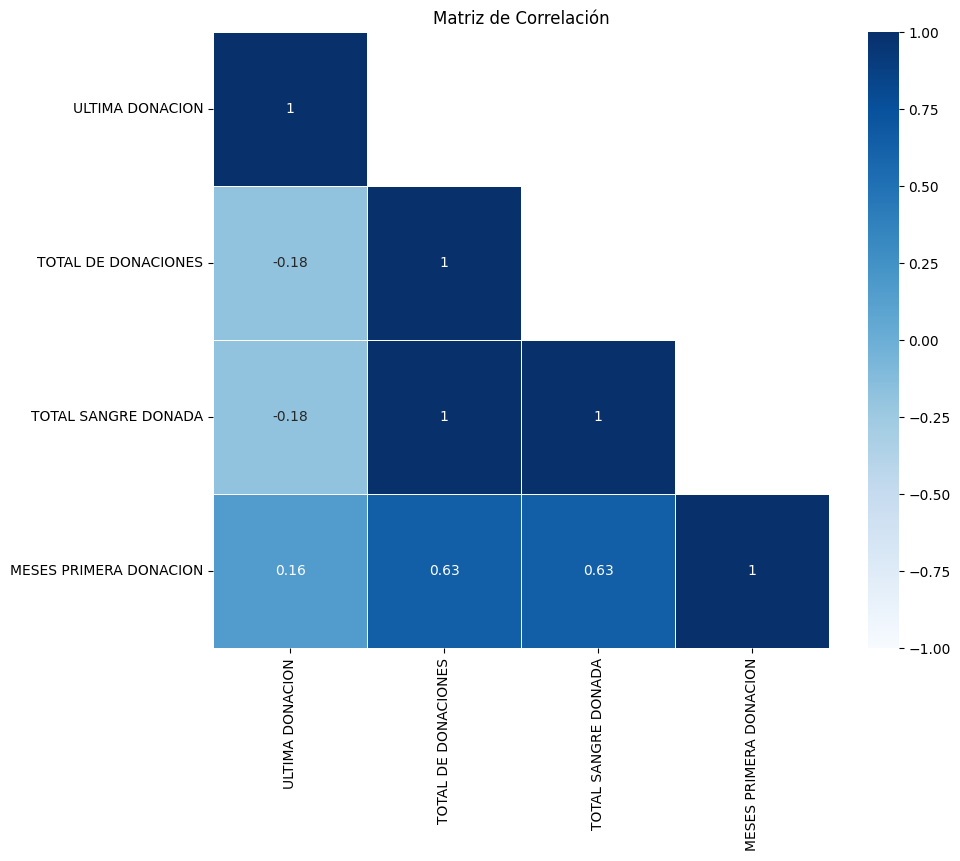

In [28]:
# Calcular la matriz de correlación excluyendo la columna 'Donador'
correlation_matrix = df.iloc[:, :-1].corr()

# Crear una máscara para la parte superior de la matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Crear el mapa de calor de la matriz de correlación con la máscara aplicada
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='Blues', vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()



# Modelos de clasificación

## Árboles aleatorios

In [29]:
#Datos de prueba y de entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.30, random_state = 101)

In [30]:
# Definición de los parámetros a optimizar 
param_grid = { 
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10, 20] 
    }

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=101, 
                                                            bootstrap=True, 
                                                            criterion="gini",
                                                            max_features="sqrt"),
                                                            param_grid=param_grid, 
                                                            cv=5, 
                                                            n_jobs=-1, 
                                                            verbose=2)

# Entrenar el Modelo
grid_search.fit(X_train, Y_train)                                     

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [31]:
# Evaluar el Mejor Modelo
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor precisión en validación:", grid_search.best_score_)

Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
Mejor precisión en validación: 0.7935347985347987


In [32]:
# Predecir con el mejor modelo
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")
print("Reporte de Clasificación:")
print(classification_report(Y_test, Y_pred))

Precisión en el conjunto de prueba: 0.80
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.81      0.95      0.87       168
           2       0.70      0.33      0.45        57

    accuracy                           0.80       225
   macro avg       0.76      0.64      0.66       225
weighted avg       0.78      0.80      0.77       225



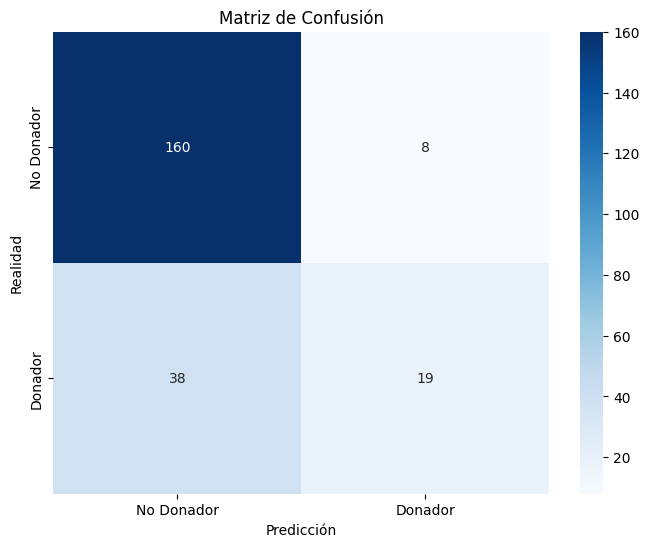

In [33]:
# Matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)

# Crear una figura y un eje
plt.figure(figsize=(8, 6))

# Crear un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Donador', 'Donador'], yticklabels=['No Donador', 'Donador'])

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

# Mostrar la gráfica
plt.show()

In [34]:
# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = cm.ravel()

# Instancias correctamente clasificadas
correctly_classified = TN + TP
print("Instancias correctamente clasificadas:", correctly_classified)

# Instancias incorrectamente clasificadas
incorrectly_classified = FP + FN
print("Instancias incorrectamente clasificadas:", incorrectly_classified)

# Tasa de verdaderos positivos (TP Rate)
tp_rate = TP / (TP + FN)
print(f"Tasa de verdaderos positivos (TP Rate){round(tp_rate*100,2)}%")

# Tasa de falsos positivos (FP Rate)
fp_rate = FP / (FP + TN)
print(f"Tasa de falsos positivos (FP Rate):{round(fp_rate*100,2)}%")


Instancias correctamente clasificadas: 179
Instancias incorrectamente clasificadas: 46
Tasa de verdaderos positivos (TP Rate)33.33%
Tasa de falsos positivos (FP Rate):4.76%


## RIPPER

## RIPPER sin manejo de desbalance de datos

In [35]:
# Separación de datos en datos de prueba y entrenamiento
X_RCD = df.drop(columns=['DONADOR'])
y_RCD = df['DONADOR']

# Convertir la etiqueta a tipo categórico y luego a numérico
y_RCD = y_RCD.astype('category').cat.codes


# Dividir datos en entrenamiento y prueba
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_RCD, y_RCD, test_size=0.3, random_state=101)

# Crear un DataFrame combinado para el entrenamiento
train_data_CD = pd.concat([X_train_CD, y_train_CD], axis=1)
train_data_CD.columns = list(X_train_CD.columns) + ['DONADOR']

# Crear y entrenar modelo RIPPER
model_CD = lw.RIPPER(random_state=101)
model_CD.fit(train_data_CD, class_feat="DONADOR")

# Predecir sobre los datos de prueba
y_pred_CD = model_CD.predict(X_test_CD)

In [36]:
# Evaluar el modelo
# Evaluar el mejor modelo
best_model_CD = random_search_CD.best_estimator_
accuracy_CD = best_model.score(X_test_CD, y_test_CD)
print(f'Accuracy del mejor modelo: {accuracy}')
print("Reporte de clasificación:\n", classification_report(y_test_CD, y_test_CD))

NameError: name 'random_search_CD' is not defined

In [ ]:
# Mostrar las reglas generadas por RIPPER
print("Reglas del modelo:")
for i in model_CD.ruleset_:
    print(i)

Reglas del modelo:
[ULTIMADONACION=<2.0^TOTALDEDONACIONES=>12.0]
[ULTIMADONACION=2.0-4.0^TOTALDEDONACIONES=3.0-5.0^MESESPRIMERADONACION=28.0-35.0]


In [ ]:
# Ejemplo: verificar instancias que cumplen una regla
condicion = (df['ULTIMA DONACION'] <= 2.0) & \
            (df['MESES PRIMERA DONACION'].between(28.0, 35.0)) & \
            (df['TOTAL DE DONACIONES'].between(6.0, 7.0))

# Contar clases para las instancias que cumplen la regla
print(df[condicion]['DONADOR'].value_counts())

DONADOR
2    6
1    2
Name: count, dtype: int64


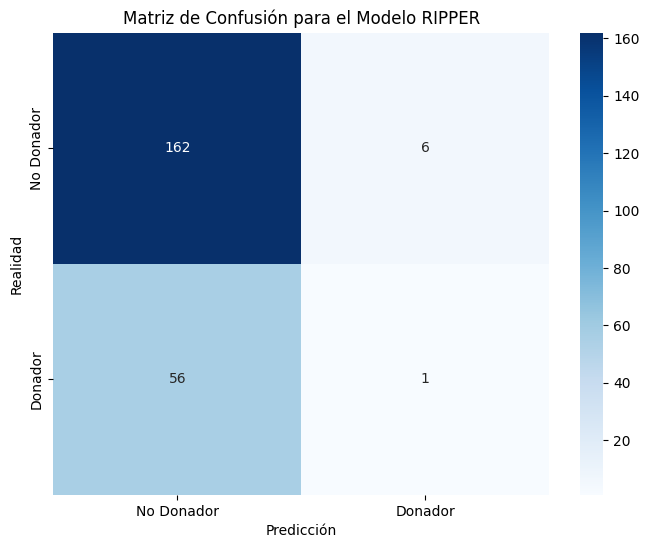

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test_CD, y_pred_CD)

# Crear una figura y un eje
plt.figure(figsize=(8, 6))

# Crear un mapa de calor para la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Donador', 'Donador'], yticklabels=['No Donador', 'Donador'])

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión para el Modelo RIPPER')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

# Mostrar la gráfica
plt.show()


In [ ]:
# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = cm.ravel()

# Calcular Tasa de Falsos Positivos (FP Rate)
fp_rate_CD = FP / (FP + TN)

# Calcular Tasa de Verdaderos Positivos (TP Rate)
tp_rate_CD = TP / (TP + FN)

# Calcular Instancias Incorrectamente Clasificadas
incorrectly_classified_CD = FP + FN

# Calcular Instancias Correctamente Clasificadas
correctly_classified_CD = TN + TP

# Imprimir los resultados
print("Tasa de Falsos Positivos (FP Rate):", fp_rate_CD)
print("Tasa de Verdaderos Positivos (TP Rate):", tp_rate_CD)
print("Instancias Incorrectamente Clasificadas:", incorrectly_classified_CD)
print("Instancias Correctamente Clasificadas:", correctly_classified_CD)

Tasa de Falsos Positivos (FP Rate): 0.03571428571428571
Tasa de Verdaderos Positivos (TP Rate): 0.017543859649122806
Instancias Incorrectamente Clasificadas: 62
Instancias Correctamente Clasificadas: 163


## RIPPER con manejo de desbalance de datos

In [ ]:
# Separación de datos en datos de prueba y entrenamiento
X_RSD = df.drop(columns=['DONADOR'])
y_RSD = df['DONADOR']

# Convertir la etiqueta a tipo categórico y luego a numérico
y_RSD = y_RSD.astype('category').cat.codes

# Manejo del desbalance de clases: aplicar SMOTE
smote_SD = SMOTE(random_state=101)
X_resampled_SD, y_resampled_SD = smote_SD.fit_resample(X_RSD, y_RSD)

# Dividir datos en entrenamiento y prueba
X_train_SD, X_test_SD, y_train_SD, y_test_SD = train_test_split(X_resampled_SD, y_resampled_SD, test_size=0.3, random_state=101)

# Crear un DataFrame combinado para el entrenamiento
train_data_SD = pd.concat([X_train_SD, y_train_SD], axis=1)
train_data_SD.columns = list(X_train_SD.columns) + ['DONADOR']

# Crear y entrenar modelo RIPPER
model_SD = RIPPER(random_state=101)
model_SD.fit(train_data_SD, class_feat="DONADOR")

# Predecir sobre los datos de prueba
y_pred_SD = model_SD.predict(X_test_SD)


In [ ]:
# Evaluar el modelo
print("Reporte de clasificación:\n", classification_report(y_test_SD, y_pred_SD))

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.53      0.90      0.67       162
           1       0.75      0.27      0.40       180

    accuracy                           0.57       342
   macro avg       0.64      0.59      0.53       342
weighted avg       0.65      0.57      0.53       342



In [ ]:
# Mostrar las reglas generadas por RIPPER
print("Reglas del modelo:")
for i in model_SD.ruleset_:
    print(i)

Reglas del modelo:
[ULTIMADONACION=<2.0^TOTALDEDONACIONES=5.0-7.0^MESESPRIMERADONACION=34.0-40.0]
[ULTIMADONACION=<2.0^TOTALSANGREDONADA=>3250.0]
[ULTIMADONACION=<2.0^TOTALDEDONACIONES=5.0-7.0]
[ULTIMADONACION=2.0-3.0^TOTALDEDONACIONES=4.0-5.0]
[ULTIMADONACION=2.0-3.0^TOTALDEDONACIONES=9.0-13.0]
[ULTIMADONACION=3.0-4.0^TOTALDEDONACIONES=>13.0]
[ULTIMADONACION=<2.0^MESESPRIMERADONACION=4.0-13.0]
[ULTIMADONACION=4.0-8.0^MESESPRIMERADONACION=4.0-13.0]


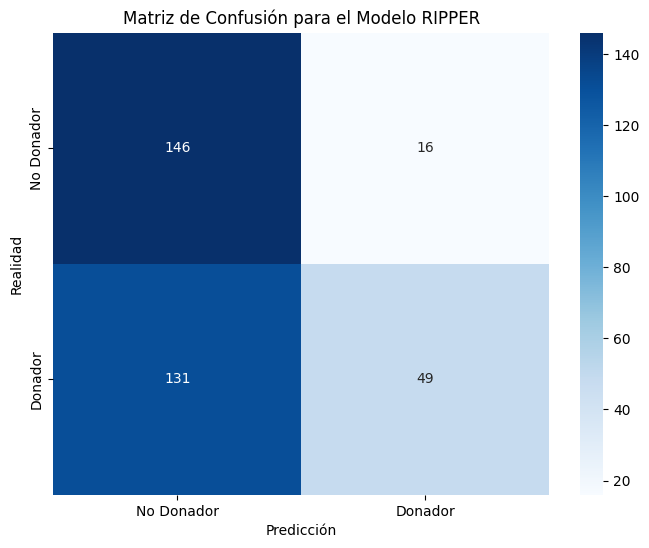

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test_SD, y_pred_SD)

# Crear una figura y un eje
plt.figure(figsize=(8, 6))

# Crear un mapa de calor para la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Donador', 'Donador'], yticklabels=['No Donador', 'Donador'])

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión para el Modelo RIPPER')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

# Mostrar la gráfica
plt.show()

In [ ]:
# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = cm.ravel()

# Calcular Tasa de Falsos Positivos (FP Rate)
fp_rate_SD = FP / (FP + TN)

# Calcular Tasa de Verdaderos Positivos (TP Rate)
tp_rate_SD = TP / (TP + FN)

# Calcular Instancias Incorrectamente Clasificadas
incorrectly_classified_SD = FP + FN

# Calcular Instancias Correctamente Clasificadas
correctly_classified_SD = TN + TP

# Imprimir los resultados
print("Tasa de Falsos Positivos (FP Rate):", fp_rate_SD)
print("Tasa de Verdaderos Positivos (TP Rate):", tp_rate_SD)
print("Instancias Incorrectamente Clasificadas:", incorrectly_classified_SD)
print("Instancias Correctamente Clasificadas:", correctly_classified_SD)

Tasa de Falsos Positivos (FP Rate): 0.09876543209876543
Tasa de Verdaderos Positivos (TP Rate): 0.2722222222222222
Instancias Incorrectamente Clasificadas: 147
Instancias Correctamente Clasificadas: 195
